<a href="https://colab.research.google.com/github/Makiato1999/ECG-Detector/blob/main/anomaly_detection_cnn_autoencoders_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, os, platform, sys
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi

PyTorch: 2.9.0+cu126
CUDA available: True
Fri Dec  5 22:52:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
import os
from types import SimpleNamespace
from sklearn.metrics import f1_score, accuracy_score, recall_score

matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Download dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartbeat' dataset.
Path to dataset files: /kaggle/input/heartbeat


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


# Dataset: Segmented and Preprocessed ECG Signals for Heartbeat

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

Source: https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data?select=ptbdb_normal.csv

In [5]:
normal_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_abnormal.csv").iloc[:, :-1]
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In [6]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


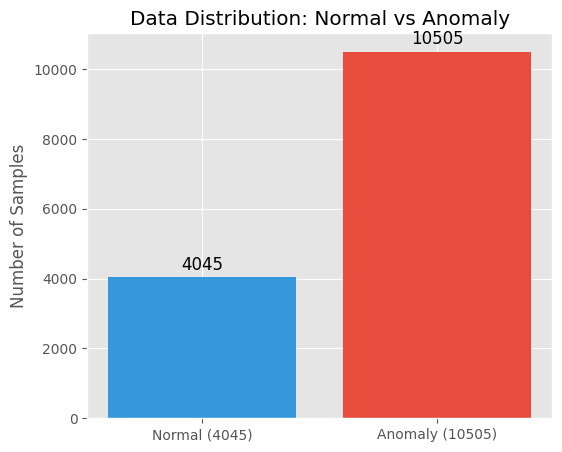

In [ ]:

counts = [len(normal_df), len(anomaly_df)]
labels = [f'Normal ({len(normal_df)})', f'Anomaly ({len(anomaly_df)})']
colors = ['#3498db', '#e74c3c']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, yval, ha='center', va='bottom', fontsize=12)

plt.title("Data Distribution: Normal vs Anomaly")
plt.ylabel("Number of Samples")
plt.show()

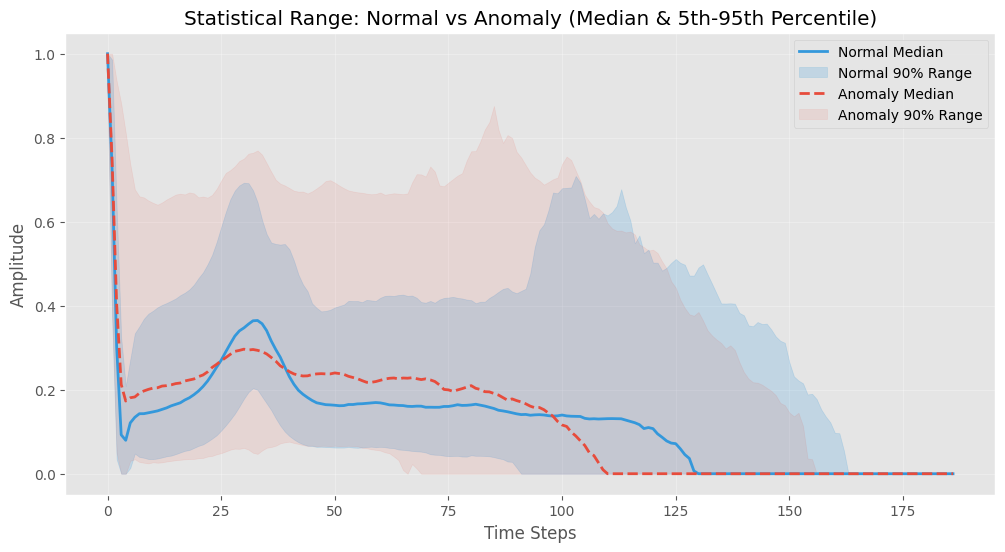

In [ ]:

def plot_percentile_range(normal, anomaly):
    plt.figure(figsize=(12, 6))

    def get_stats(df):
        median = np.nanpercentile(df, 50, axis=0)
        lower = np.nanpercentile(df, 5, axis=0)
        upper = np.nanpercentile(df, 95, axis=0)
        return median, lower, upper

    norm_mid, norm_low, norm_high = get_stats(normal)

    anom_mid, anom_low, anom_high = get_stats(anomaly)

    plt.plot(norm_mid, color='#3498db', linewidth=2, label='Normal Median')
    plt.fill_between(range(187), norm_low, norm_high, color='#3498db', alpha=0.2, label='Normal 90% Range')

    plt.plot(anom_mid, color='#e74c3c', linewidth=2, linestyle='--', label='Anomaly Median')
    plt.fill_between(range(187), anom_low, anom_high, color='#e74c3c', alpha=0.1, label='Anomaly 90% Range')

    plt.title("Statistical Range: Normal vs Anomaly (Median & 5th-95th Percentile)")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_percentile_range(normal_df, anomaly_df)

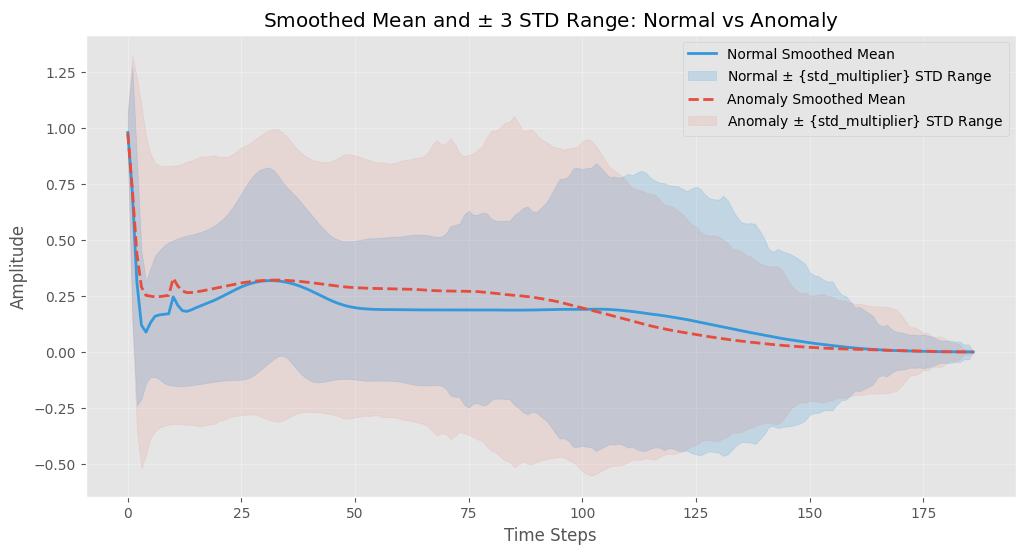

In [ ]:
time_steps = normal_df.shape[1] # 187

def calculate_smoothed_mean_stats_fixed(df, std_multiplier=3, window_size=20):

    mean_signal = df.mean(axis=0)
    std_signal = df.std(axis=0)

    smoothed_mean = mean_signal.rolling(window=window_size, center=True).mean()
    smoothed_mean = smoothed_mean.fillna(mean_signal)

    upper_bound = mean_signal + std_signal * std_multiplier
    lower_bound = mean_signal - std_signal * std_multiplier

    return smoothed_mean.values, lower_bound.values, upper_bound.values

def plot_smoothed_range(normal_df, anomaly_df, std_multiplier=3, window_size=20):
    plt.figure(figsize=(12, 6))

    time_steps_range = range(normal_df.shape[1])

    norm_mean, norm_low, norm_high = calculate_smoothed_mean_stats_fixed(
        normal_df, std_multiplier=std_multiplier, window_size=window_size
    )

    anom_mean, anom_low, anom_high = calculate_smoothed_mean_stats_fixed(
        anomaly_df, std_multiplier=std_multiplier, window_size=window_size
    )

    NORMAL_COLOR = '#3498db'

    plt.plot(time_steps_range, norm_mean, color=NORMAL_COLOR, linewidth=2, label='Normal Smoothed Mean')

    plt.fill_between(time_steps_range, norm_low, norm_high, color=NORMAL_COLOR, alpha=0.2, label=r'Normal $\pm$ {std_multiplier} STD Range')


    ANOMALY_COLOR = '#e74c3c'

    plt.plot(time_steps_range, anom_mean, color=ANOMALY_COLOR, linewidth=2, linestyle='--', label='Anomaly Smoothed Mean')

    plt.fill_between(time_steps_range, anom_low, anom_high, color=ANOMALY_COLOR, alpha=0.1, label=r'Anomaly $\pm$ {std_multiplier} STD Range')


    plt.title(r"Smoothed Mean and $\pm$ 3 STD Range: Normal vs Anomaly")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_smoothed_range(normal_df, anomaly_df)

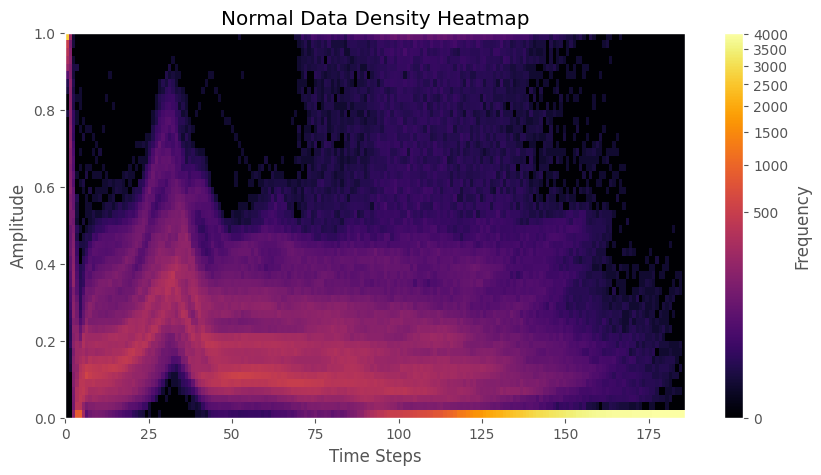

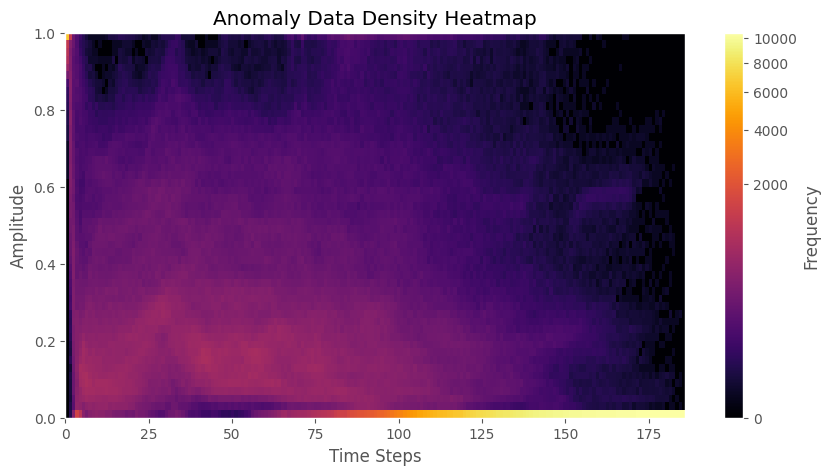

In [ ]:

import matplotlib.colors as mcolors

def plot_density_heatmap(df, title):
    x = np.tile(np.arange(187), len(df))
    y = df.values.flatten()

    plt.figure(figsize=(10, 5))
    plt.hist2d(x, y, bins=[187, 50], cmap='inferno', norm=mcolors.PowerNorm(0.3))
    plt.colorbar(label='Frequency')
    plt.title(f"{title} Density Heatmap")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.show()

plot_density_heatmap(normal_df, "Normal Data")

plot_density_heatmap(anomaly_df, "Anomaly Data")

Normal Data Range: [0.00, 1.00]
Anomaly Data Range: [0.00, 1.00]


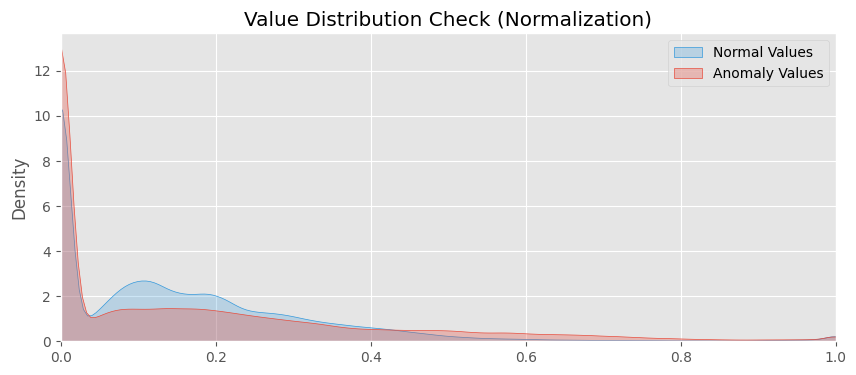

In [ ]:

print(f"Normal Data Range: [{normal_df.min().min():.2f}, {normal_df.max().max():.2f}]")
print(f"Anomaly Data Range: [{anomaly_df.min().min():.2f}, {anomaly_df.max().max():.2f}]")

plt.figure(figsize=(10, 4))
sns.kdeplot(normal_df.values.flatten(), color='#3498db', fill=True, label='Normal Values')
sns.kdeplot(anomaly_df.values.flatten(), color='#e74c3c', fill=True, label='Anomaly Values', alpha=0.3)
plt.title("Value Distribution Check (Normalization)")
plt.xlim(0, 1)
plt.legend()
plt.show()

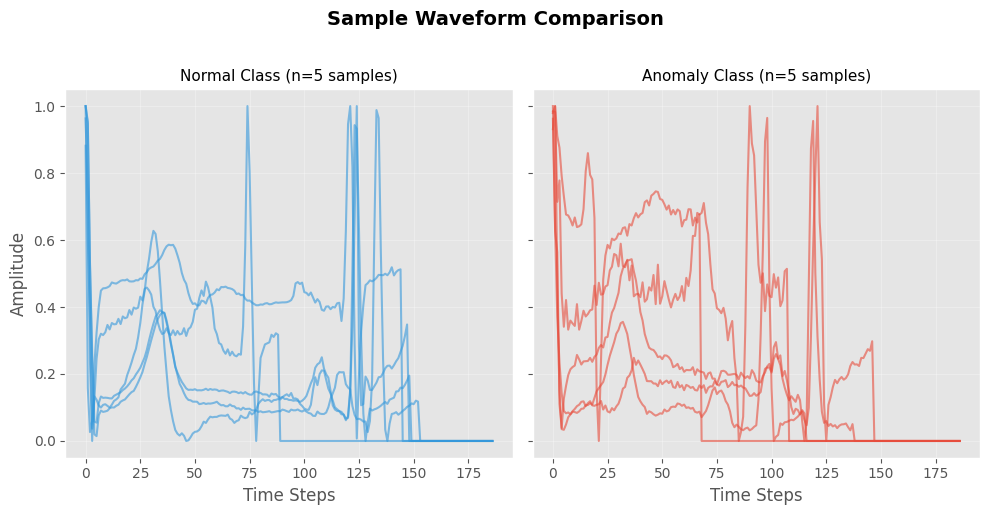

In [ ]:

def plot_sample_overlay(normal_df, anomaly_df, n_samples=5, title="Sample Waveform Comparison"):

    n_normal = min(n_samples, len(normal_df))
    n_anomaly = min(n_samples, len(anomaly_df))

    normal_indices = np.random.randint(0, len(normal_df), n_normal)
    anomaly_indices = np.random.randint(0, len(anomaly_df), n_anomaly)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

    NORMAL_COLOR = '#3498db'

    for i, idx in enumerate(normal_indices):
        label = f"Sample {idx}" if i == 0 else None 
        ax[0].plot(normal_df.iloc[idx, :].values, color=NORMAL_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[0].set_title(f"Normal Class (n={n_normal} samples)", fontsize=11)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid(True, alpha=0.3)
    

    ANOMALY_COLOR = '#e74c3c'

    for i, idx in enumerate(anomaly_indices):
        label = f"Sample {idx}" if i == 0 else None
        ax[1].plot(anomaly_df.iloc[idx, :].values, color=ANOMALY_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[1].set_title(f"Anomaly Class (n={n_anomaly} samples)", fontsize=11)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.3)
    # ax[1].legend(loc='upper right', fontsize=9)

    plt.suptitle(title, fontsize=14, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_sample_overlay(normal_df, anomaly_df, n_samples=5)

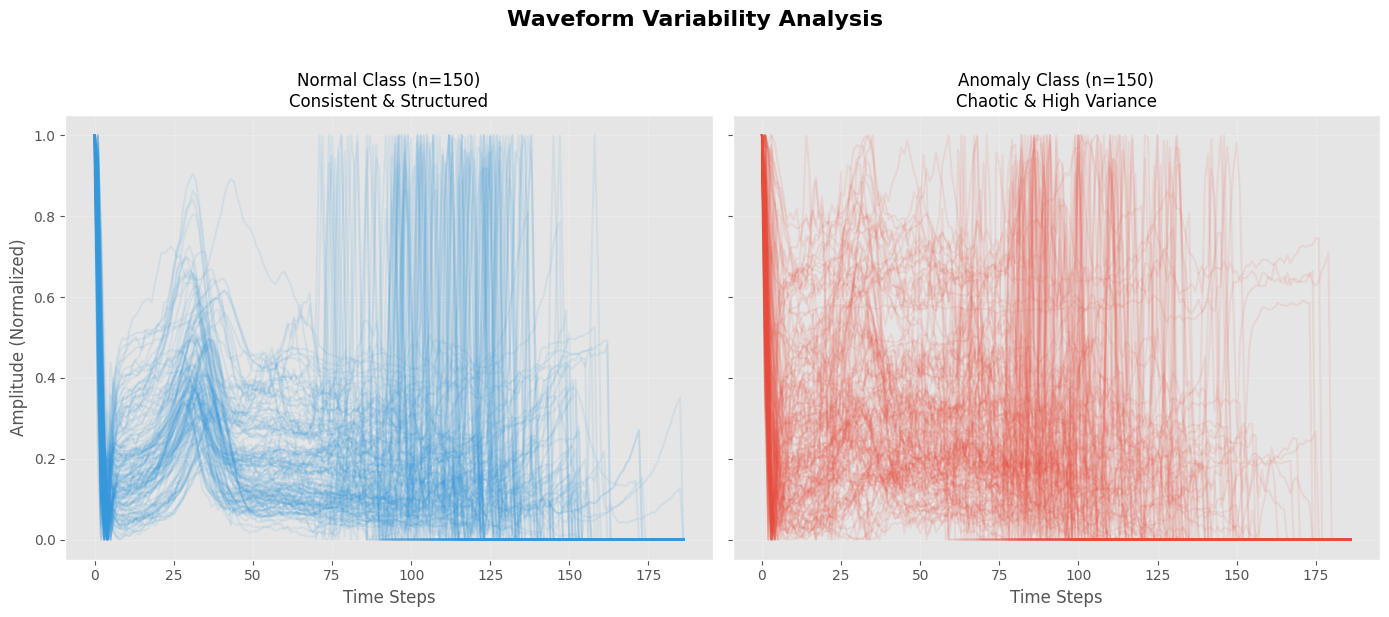

In [ ]:

def plot_waveform_overlay(normal, anomaly, n_samples=150, title="Waveform Variability Analysis"):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 6))


    normal_indices = np.random.randint(0, len(normal), n_samples)

    for i in normal_indices:
        ax[0].plot(normal.iloc[i, :].values, color='#3498db', alpha=0.1, linewidth=1.5)

    ax[0].set_title(f"Normal Class (n={n_samples})\nConsistent & Structured", fontsize=12)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude (Normalized)")
    ax[0].grid(True, alpha=0.2) 

    anomaly_indices = np.random.randint(0, len(anomaly), n_samples)

    for i in anomaly_indices:
        ax[1].plot(anomaly.iloc[i, :].values, color='#e74c3c', alpha=0.1, linewidth=1.5)

    ax[1].set_title(f"Anomaly Class (n={n_samples})\nChaotic & High Variance", fontsize=12)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.2)

    plt.suptitle(title, fontsize=16, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_waveform_overlay(normal_df, anomaly_df, n_samples=150)

# Configuration

In [14]:
from dataclasses import dataclass

@dataclass
class Config:
    epochs: int = 50
    learning_rate: float = 0.001
    batch_size: int = 64
    use_augmentation: bool = False
    input_dim: int = 187
    latent_dim: int = 32
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    save_path: str = './checkpoints'
    model_name: str = 'best_autoencoder.pth'

config = Config(
    epochs=50,
    learning_rate=0.001,
    batch_size=64,
    use_augmentation=True,
    input_dim = 187,
    latent_dim = 32,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Normal-only Scaler

In [15]:
normal = normal_df.to_numpy().astype(np.float64)
anomaly = anomaly_df.to_numpy().astype(np.float64)

In [16]:
from types import SimpleNamespace

def split_normal_data(normal, anomaly, seed=45):
    X_train, X_temp = train_test_split(
        normal, test_size=0.30, random_state=seed, shuffle=True
    )

    X_validate, X_test = train_test_split(
        X_temp, test_size=0.50, random_state=seed, shuffle=True
    )

    return SimpleNamespace(
        train=X_train,
        val=X_validate,
        test=X_test,
        anomaly=anomaly
    )

data_split = split_normal_data(normal, anomaly)

X_train = data_split.train
X_validate = data_split.val
X_test = data_split.test
anomaly = data_split.anomaly
print("Train:", X_train.shape)
print("Valid:", X_validate.shape)
print("Test :", X_test.shape)

Train: (2831, 187)
Valid: (607, 187)
Test : (607, 187)


In [ ]:
# Normal-only Scaler
from sklearn.preprocessing import StandardScaler
from types import SimpleNamespace

def scaler_data(X_train, X_validate, X_test, anomaly):
  scaler = StandardScaler()
  scaler.fit(X_train)   

  X_train_scaled    = scaler.transform(X_train)
  X_validate_scaled = scaler.transform(X_validate)
  X_test_scaled     = scaler.transform(X_test)
  anomaly_scaled    = scaler.transform(anomaly)

  print("Train:", X_train_scaled.shape)
  print("Valid:", X_validate_scaled.shape)
  print("Test :", X_test_scaled.shape)

  return SimpleNamespace(
    X_train_scaled=X_train_scaled,
    X_validate_scaled=X_validate_scaled,
    X_test_scaled=X_test_scaled,
    anomaly_scaled=anomaly_scaled,
    scaler=scaler
  )

In [ ]:
class AnomalyDetectionDataset(Dataset):
    """
    PyTorch Dataset for Autoencoder Anomaly Detection.
    X = Y = input itself.
    """
    def __init__(self, np_array):
        self.data = torch.from_numpy(np_array).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x, x  

In [19]:
def get_datasets(data_split, use_scaled = False):
  if use_scaled:
    scaled = scaler_data(
        data_split.train,
        data_split.val,
        data_split.test,
        data_split.anomaly
    )
    X_train = scaled.X_train_scaled
    X_val   = scaled.X_validate_scaled
    X_test  = scaled.X_test_scaled
    anomaly = scaled.anomaly_scaled
  else:
    X_train = data_split.train
    X_val   = data_split.val
    X_test  = data_split.test
    anomaly = data_split.anomaly

  train_ds = AnomalyDetectionDataset(X_train)
  val_ds   = AnomalyDetectionDataset(X_val)
  test_ds  = AnomalyDetectionDataset(X_test)
  anom_ds  = AnomalyDetectionDataset(anomaly)

  return SimpleNamespace(
      train=train_ds,
      val=val_ds,
      test=test_ds,
      anomaly=anom_ds
  )

In [20]:
# 6. DataLoaders
BATCH_SIZE = config.batch_size

# datasets = get_datasets(data_split, use_scaled=False)
datasets = get_datasets(data_split, use_scaled=True)


train_dataset = datasets.train
validate_dataset = datasets.val
test_dataset = datasets.test
anomaly_dataset = datasets.anomaly

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Valid batches:", len(validate_loader))
print("Test batches :", len(test_loader))
print("Anomaly batches:", len(anomaly_loader))

Train: (2831, 187)
Valid: (607, 187)
Test : (607, 187)
Train batches: 45
Valid batches: 10
Test batches : 10
Anomaly batches: 165


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Normal only visualization

In [21]:
scaled_data = scaler_data(
    data_split.train,
    data_split.val,
    data_split.test,
    data_split.anomaly
)


Train: (2831, 187)
Valid: (607, 187)
Test : (607, 187)


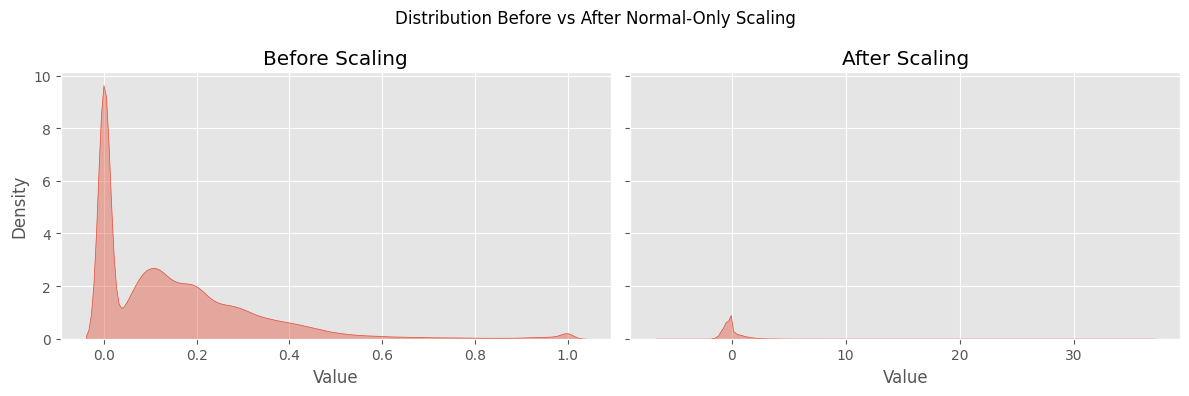

In [22]:
raw = data_split.train.reshape(-1)
scaled = scaled_data.X_train_scaled.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.kdeplot(raw, fill=True, alpha=0.4, ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Density")

sns.kdeplot(scaled, fill=True, alpha=0.4, ax=axes[1])
axes[1].set_title("After Scaling")
axes[1].set_xlabel("Value")

plt.suptitle("Distribution Before vs After Normal-Only Scaling")
plt.tight_layout()
plt.show()

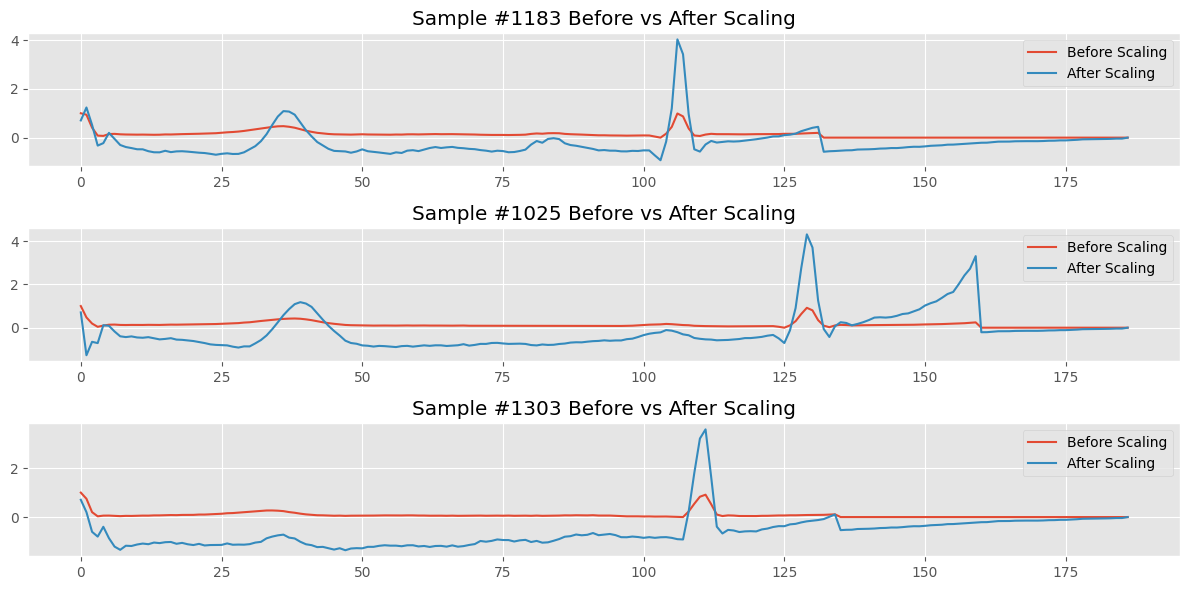

In [ ]:
idx = np.random.choice(len(X_train), size=3, replace=False)

plt.figure(figsize=(12,6))

for i, id_ in enumerate(idx):
    plt.subplot(3,1,i+1)
    plt.plot(X_train[id_], label="Before Scaling")
    plt.plot(scaled_data.X_train_scaled[id_], label="After Scaling")
    plt.title(f"Sample #{id_} Before vs After Scaling")
    plt.legend()

plt.tight_layout()
plt.show()


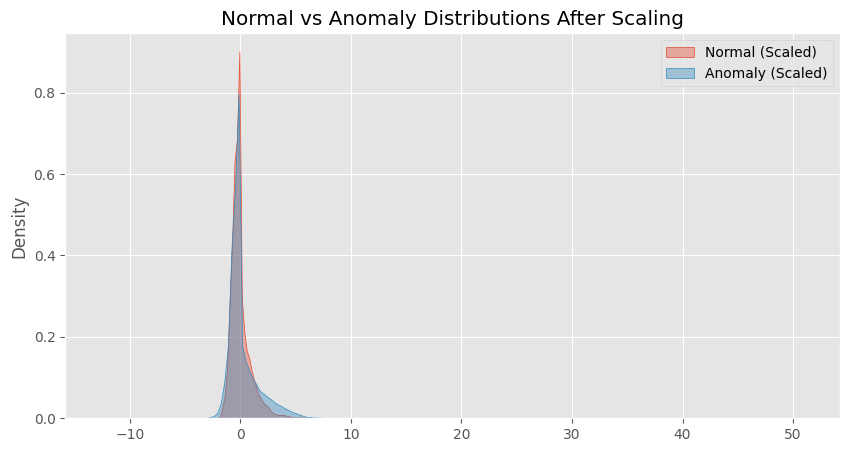

In [24]:
plt.figure(figsize=(10,5))
sns.kdeplot(scaled_data.X_train_scaled.reshape(-1), label="Normal (Scaled)", fill=True, alpha=0.4)
sns.kdeplot(scaled_data.anomaly_scaled.reshape(-1), label="Anomaly (Scaled)", fill=True, alpha=0.4)
plt.title("Normal vs Anomaly Distributions After Scaling")
plt.legend()
plt.show()


# Normal-only Data Augmentation

In [ ]:
import random

def augment_ecg(batch, jitter_std=0.01, scale_std=0.05, max_shift=2):
    """
    batch: (B, 188)
    """
    B, T = batch.shape

    # 1. jitter small noise
    jitter = torch.randn_like(batch) * jitter_std
    batch = batch + jitter

    # 2. scaling Amplitude scaling
    # scale = 1.0 + torch.randn(B, 1, device=batch.device) * scale_std
    scale = 1.0 + torch.randn_like(batch[:, :1]) * scale_std
    batch = batch * scale

    # 3. small time shift 
    shift = random.randint(-max_shift, max_shift)
    batch = torch.roll(batch, shifts=shift, dims=1)

    return batch


# data augmentation visualization

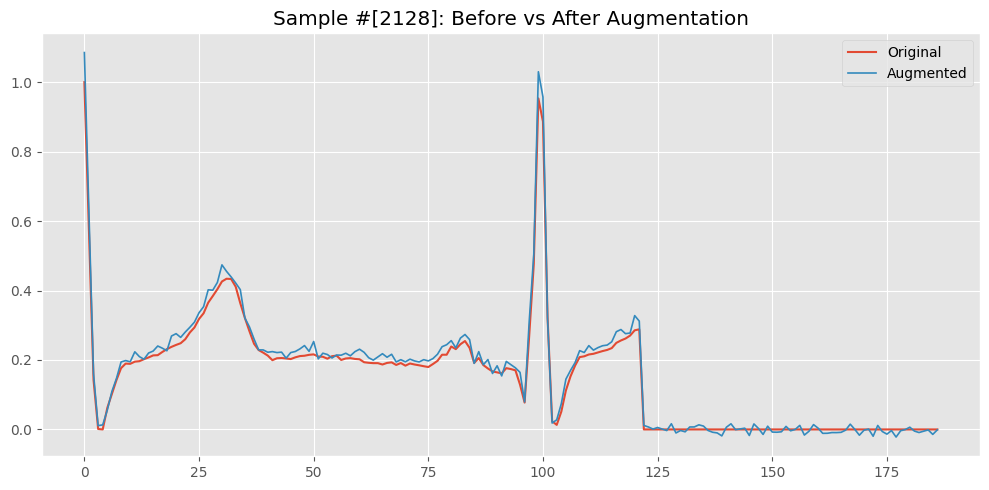

In [ ]:

num_examples=1;
idx = np.random.choice(len(normal), size=num_examples, replace=False)
original = torch.tensor(normal[idx], dtype=torch.float32)   # (5,188)

augmented = augment_ecg(original.clone())

plt.figure(figsize=(10, 5))

for i in range(num_examples):
    plt.subplot(num_examples, 1, i+1)
    plt.plot(original[i], label="Original", linewidth=1.5)
    plt.plot(augmented[i], label="Augmented", linewidth=1.2)
    plt.title(f"Sample #{idx}: Before vs After Augmentation")
    plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

# CNN Autoencoder Model

In [ ]:
torch.manual_seed(1024)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()

        # --- 1. Encoder ---
        # Conv1d Input: (Batch, Channel=1, Length=input_dim)
        self.encoder = nn.Sequential(
            # Layer 1: Conv1D(128, 3) + BN + MaxPool
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            # Layer 2: Conv1D(128, 3) + BN + MaxPool
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            # Layer 3: Conv1D(latent_dim, 3) + BN + MaxPool
            nn.Conv1d(in_channels=128, out_channels=latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # --- 2. Decoder Conv part (do not change the length, only the channel) ---
        self.decoder_conv = nn.Sequential(
            # Layer 1: Transpose(latent_dim -> latent_dim)
            nn.ConvTranspose1d(in_channels=latent_dim, out_channels=latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),

            # Layer 2: Transpose(latent_dim -> 128)
            nn.ConvTranspose1d(in_channels=latent_dim, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            # Layer 3: Transpose(128 -> 128)
            nn.ConvTranspose1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        # --- 3. Automatically calculate the Flatten size after "encoder + decoder_conv" ---
        self._flatten_size = self._get_flatten_size(input_dim, latent_dim)

        self.decoder_dense = nn.Linear(self._flatten_size, input_dim)

        self.final_activation = nn.Identity()

    def _get_flatten_size(self, input_dim, latent_dim):
        dummy_input = torch.zeros(1, 1, input_dim)   # shape: [1, 1, 187]
        with torch.no_grad():
            encoded = self.encoder(dummy_input)      # [1, latent_dim, L_enc]
            decoded = self.decoder_conv(encoded)     # [1, 128, L_dec]

        return decoded.view(1, -1).size(1)

    def forward(self, x):
        # x shape: [Batch, 187]

        # 1. Reshape for Conv1d: [Batch, 187] -> [Batch, 1, 187]
        x = x.unsqueeze(1)

        # 2. Encoder: [B, 1, 187] -> [B, latent_dim, L_enc]
        encoded = self.encoder(x)

        # 3. Decoder Conv Block: [B, latent_dim, L_enc] -> [B, 128, L_dec]
        decoded = self.decoder_conv(encoded)

        # 4. Flatten: [B, 128, L_dec] -> [B, flatten_size]
        decoded = decoded.view(decoded.size(0), -1)

        # 5. Dense to input_dim
        reconstructed = self.decoder_dense(decoded)

        reconstructed = self.final_activation(reconstructed)

        return reconstructed

In [ ]:
def train_model(model, train_loader, val_loader, config: Config):
    device = torch.device(config.device)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.L1Loss()

    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')

    print(f"Start training on {config.device} for {config.epochs} epochs...")

    for epoch in range(config.epochs):

        # --- Training Phase ---
        model.train()
        train_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(config.device)

            if config.use_augmentation:
                data_aug = augment_ecg(data).to(config.device)
            else:
                data_aug = data

            optimizer.zero_grad()
            outputs = model(data_aug)
            loss = criterion(outputs, data) 
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch, _ in val_loader:
                batch = batch.to(config.device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{config.epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # --- Save Best Model ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

            if not os.path.exists(config.save_path):
                os.makedirs(config.save_path)

            save_full_path = os.path.join(config.save_path, config.model_name)

            torch.save(model.state_dict(), save_full_path)
            print(f"  >>> Best model saved to {save_full_path}!")

    print("Training Complete.")
    return history

# Hyperparameter experiment

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

def draw_comparison_plots(results):

    def key_to_name(key):
        latent, lr, aug = key
        return f"L{latent}_LR{lr}_A{aug}"

    # -----------------------------
    # 1. Loss Curve Comparison
    # -----------------------------
    plt.figure(figsize=(5,3))
    for key, res in results.items():
        name = key_to_name(key)
        plt.plot(res["history"]["val_loss"], label=f"{name}")
    plt.title("Validation Loss Curve Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Val Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -----------------------------
    # 2. F1 Score Comparison
    # -----------------------------
    labels = []
    f1_values = []
    for key, res in results.items():
        labels.append(key_to_name(key))
        f1_values.append(res["metrics"]["f1"])

    plt.figure(figsize=(5,3))
    sns.barplot(x=labels, y=f1_values)
    plt.title("F1 Score Comparison Across Experiments")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45)
    plt.show()

    # -----------------------------
    # 3. ROC Curve Comparison
    # -----------------------------
    plt.figure(figsize=(5,5))
    for key, res in results.items():
        name = key_to_name(key)
        y_true = res["y_true"]
        y_scores = res["y_scores"]

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auc = roc_auc_score(y_true, y_scores)

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -----------------------------
    # 4. PR Curve Comparison
    # -----------------------------
    plt.figure(figsize=(5,5))
    for key, res in results.items():
        name = key_to_name(key)
        y_true = res["y_true"]
        y_scores = res["y_scores"]

        prec, rec, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)

        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


In [56]:
def draw_single_experiment(res):

    history = res["history"]
    raw_mae_validate = res["raw_mae_validate"]
    raw_mae_anomaly  = res["raw_mae_anomaly"]
    threshold        = res["threshold"]
    y_true           = res["y_true"]
    y_pred           = res["y_pred"]
    y_scores         = res["y_scores"]

    # 1. Loss Curve
    plt.figure(figsize=(5,3))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("L1 Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. MAE Distribution
    plt.figure(figsize=(10,5))
    sns.histplot(raw_mae_validate, bins=50, color='blue', label="Normal", alpha=0.6)
    sns.histplot(raw_mae_anomaly, bins=50, color='red', label="Anomaly", alpha=0.6)
    plt.axvline(threshold, color='green', linestyle='--', label=f"Threshold: {threshold:.4f}")
    plt.title("MAE Distribution")
    plt.legend()
    plt.show()

    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Anomaly"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # 4. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. PR Curve
    prec, rec, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(5,5))
    plt.plot(rec, prec, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def compute_raw_mae(model, loader, scaler, device="cuda"):
    model.eval()
    mae_list = []

    with torch.no_grad():
        for batch, _ in loader:
            batch = batch.to(device)

            recon = model(batch)

            orig = batch.cpu().numpy()
            recon = recon.cpu().numpy()

            orig_raw = scaler.inverse_transform(orig)
            recon_raw = scaler.inverse_transform(recon)

            mae = np.mean(np.abs(orig_raw - recon_raw), axis=1)
            mae_list.append(mae)

    return np.concatenate(mae_list)


def find_threshold_statistical(loss):
    mean_loss = loss.mean()
    std_loss = loss.std()

    threshold = mean_loss + 1.0 * std_loss
    print(f"Statistical threshold (Mean + 1*STD): {threshold:.5f}")
    return threshold


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_result(raw_mae_test, raw_mae_anomaly, threshold):
    print("\n=== Final test results ===")

    y_test_true = np.zeros_like(raw_mae_test)
    y_test_pred = (raw_mae_test > threshold).astype(int)

    y_anom_true = np.ones_like(raw_mae_anomaly)
    y_anom_pred = (raw_mae_anomaly > threshold).astype(int)

    y_true = np.concatenate([y_test_true, y_anom_true])
    y_pred = np.concatenate([y_test_pred, y_anom_pred])

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Overall Accuracy:  {acc*100:.2f}%")
    print(f"Precision (Anom):  {prec*100:.2f}%")
    print(f"Recall (Anom):     {rec*100:.2f}%")
    print(f"F1 Score:          {f1*100:.2f}%")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }


In [ ]:
from copy import deepcopy

results = {}

latent_list = [16, 32, 64]
lr_list = [1e-4, 1e-3]
aug_list = [False, True]

# latent_list = [32]
# lr_list = [1e-3]
# aug_list = [True]


for latent_dim in latent_list:
    for lr in lr_list:
        for aug in aug_list:

            print("\n======================================")
            print(f"Running Experiment: latent={latent_dim}, lr={lr}, aug={aug}")
            print("======================================")

            exp_config = deepcopy(config)
            exp_config.latent_dim = latent_dim
            exp_config.learning_rate = lr
            exp_config.use_augmentation = aug
            exp_config.model_name = f"ae_lat{latent_dim}_lr{lr}_aug{aug}.pth"

            model = AutoEncoder(
                input_dim=exp_config.input_dim,
                latent_dim=exp_config.latent_dim
            )

            history = train_model(
                model=model,
                train_loader=train_loader,
                val_loader=validate_loader,
                config=exp_config
            )

            raw_mae_train = compute_raw_mae(model, train_loader, scaler, device=exp_config.device)
            threshold = find_threshold_statistical(raw_mae_train)

            raw_mae_validate = compute_raw_mae(model, validate_loader, scaler, device=exp_config.device)

            raw_mae_test     = compute_raw_mae(model, test_loader, scaler, device=exp_config.device)
            raw_mae_anomaly  = compute_raw_mae(model, anomaly_loader, scaler, device=exp_config.device)

            metrics = evaluate_result(raw_mae_test, raw_mae_anomaly, threshold)

            y_true = np.concatenate([
                np.zeros_like(raw_mae_test),
                np.ones_like(raw_mae_anomaly)
            ])

            y_pred = np.concatenate([
                (raw_mae_test > threshold).astype(int),
                (raw_mae_anomaly > threshold).astype(int)
            ])

            y_scores = np.concatenate([raw_mae_test, raw_mae_anomaly])




            key = (latent_dim, lr, aug)
            results[key] = {
                "history": history,
                "threshold": threshold,
                "metrics": metrics,
                "raw_mae_validate": raw_mae_validate,
                "raw_mae_test": raw_mae_test,
                "raw_mae_anomaly": raw_mae_anomaly,
                "y_true": y_true,
                "y_pred": y_pred,
                "y_scores": y_scores
            }

            print(f"\n>>> End of experiment：F1 = {metrics['f1']:.4f}")
            print("======================================")



Running Experiment: latent=16, lr=0.0001, aug=False
Start training on cuda for 50 epochs...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.441425 | Val Loss: 0.330753
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augFalse.pth!
Epoch [2/50] Train Loss: 0.288543 | Val Loss: 0.261807
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augFalse.pth!
Epoch [3/50] Train Loss: 0.252670 | Val Loss: 0.237666
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augFalse.pth!
Epoch [4/50] Train Loss: 0.227538 | Val Loss: 0.213167
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augFalse.pth!
Epoch [5/50] Train Loss: 0.203615 | Val Loss: 0.198919
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augFalse.pth!
Epoch [6/50] Train Loss: 0.191775 | Val Loss: 0.193677
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augFalse.pth!
Epoch [7/50] Train Loss: 0.180819 | Val Loss: 0.176282
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augFalse.pth!
Epoch [8/50] Train Loss: 0.166107 | Val Loss: 0.165972
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.000

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.462192 | Val Loss: 0.337767
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augTrue.pth!
Epoch [2/50] Train Loss: 0.299893 | Val Loss: 0.273966
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augTrue.pth!
Epoch [3/50] Train Loss: 0.263549 | Val Loss: 0.240446
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augTrue.pth!
Epoch [4/50] Train Loss: 0.243186 | Val Loss: 0.223619
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augTrue.pth!
Epoch [5/50] Train Loss: 0.226589 | Val Loss: 0.208552
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augTrue.pth!
Epoch [6/50] Train Loss: 0.221296 | Val Loss: 0.200424
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augTrue.pth!
Epoch [7/50] Train Loss: 0.209694 | Val Loss: 0.194377
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.0001_augTrue.pth!
Epoch [8/50] Train Loss: 0.208771 | Val Loss: 0.196684
Epoch [9/50] Train Loss: 0.203704 | Val Loss: 0.184781
  >>> Be

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.359095 | Val Loss: 0.262214
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augFalse.pth!
Epoch [2/50] Train Loss: 0.242357 | Val Loss: 0.225542
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augFalse.pth!
Epoch [3/50] Train Loss: 0.214344 | Val Loss: 0.198493
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augFalse.pth!
Epoch [4/50] Train Loss: 0.172357 | Val Loss: 0.162378
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augFalse.pth!
Epoch [5/50] Train Loss: 0.160151 | Val Loss: 0.179862
Epoch [6/50] Train Loss: 0.145490 | Val Loss: 0.142562
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augFalse.pth!
Epoch [7/50] Train Loss: 0.135769 | Val Loss: 0.135125
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augFalse.pth!
Epoch [8/50] Train Loss: 0.127999 | Val Loss: 0.120696
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augFalse.pth!
Epoch [9/50] Train Loss: 0.121581 | Val Loss: 0.127600
Epoch [1

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.377213 | Val Loss: 0.277672
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augTrue.pth!
Epoch [2/50] Train Loss: 0.260468 | Val Loss: 0.226967
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augTrue.pth!
Epoch [3/50] Train Loss: 0.238231 | Val Loss: 0.225206
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augTrue.pth!
Epoch [4/50] Train Loss: 0.217988 | Val Loss: 0.194069
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augTrue.pth!
Epoch [5/50] Train Loss: 0.209137 | Val Loss: 0.180694
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augTrue.pth!
Epoch [6/50] Train Loss: 0.203185 | Val Loss: 0.177520
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augTrue.pth!
Epoch [7/50] Train Loss: 0.190199 | Val Loss: 0.169893
  >>> Best model saved to ./checkpoints/ae_lat16_lr0.001_augTrue.pth!
Epoch [8/50] Train Loss: 0.196273 | Val Loss: 0.181058
Epoch [9/50] Train Loss: 0.189090 | Val Loss: 0.159719
  >>> Best mode

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.444424 | Val Loss: 0.312985
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augFalse.pth!
Epoch [2/50] Train Loss: 0.289703 | Val Loss: 0.262933
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augFalse.pth!
Epoch [3/50] Train Loss: 0.244406 | Val Loss: 0.230287
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augFalse.pth!
Epoch [4/50] Train Loss: 0.225447 | Val Loss: 0.212175
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augFalse.pth!
Epoch [5/50] Train Loss: 0.209240 | Val Loss: 0.208632
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augFalse.pth!
Epoch [6/50] Train Loss: 0.194393 | Val Loss: 0.185585
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augFalse.pth!
Epoch [7/50] Train Loss: 0.181172 | Val Loss: 0.177701
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augFalse.pth!
Epoch [8/50] Train Loss: 0.170092 | Val Loss: 0.166463
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.000

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.449624 | Val Loss: 0.317358
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augTrue.pth!
Epoch [2/50] Train Loss: 0.300287 | Val Loss: 0.270844
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augTrue.pth!
Epoch [3/50] Train Loss: 0.261633 | Val Loss: 0.234855
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augTrue.pth!
Epoch [4/50] Train Loss: 0.236140 | Val Loss: 0.217520
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augTrue.pth!
Epoch [5/50] Train Loss: 0.224042 | Val Loss: 0.204778
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augTrue.pth!
Epoch [6/50] Train Loss: 0.215537 | Val Loss: 0.194261
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augTrue.pth!
Epoch [7/50] Train Loss: 0.210270 | Val Loss: 0.195859
Epoch [8/50] Train Loss: 0.202849 | Val Loss: 0.182107
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.0001_augTrue.pth!
Epoch [9/50] Train Loss: 0.198963 | Val Loss: 0.182975
Epoch [1

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.353738 | Val Loss: 0.277079
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augFalse.pth!
Epoch [2/50] Train Loss: 0.240847 | Val Loss: 0.248396
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augFalse.pth!
Epoch [3/50] Train Loss: 0.191127 | Val Loss: 0.186806
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augFalse.pth!
Epoch [4/50] Train Loss: 0.158620 | Val Loss: 0.149381
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augFalse.pth!
Epoch [5/50] Train Loss: 0.142454 | Val Loss: 0.144871
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augFalse.pth!
Epoch [6/50] Train Loss: 0.143567 | Val Loss: 0.140619
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augFalse.pth!
Epoch [7/50] Train Loss: 0.124754 | Val Loss: 0.115180
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augFalse.pth!
Epoch [8/50] Train Loss: 0.120691 | Val Loss: 0.120923
Epoch [9/50] Train Loss: 0.128539 | Val Loss: 0.118899
Epoch [1

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.365935 | Val Loss: 0.269642
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augTrue.pth!
Epoch [2/50] Train Loss: 0.257641 | Val Loss: 0.236069
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augTrue.pth!
Epoch [3/50] Train Loss: 0.223353 | Val Loss: 0.194250
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augTrue.pth!
Epoch [4/50] Train Loss: 0.209844 | Val Loss: 0.184610
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augTrue.pth!
Epoch [5/50] Train Loss: 0.202789 | Val Loss: 0.180358
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augTrue.pth!
Epoch [6/50] Train Loss: 0.198208 | Val Loss: 0.179149
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augTrue.pth!
Epoch [7/50] Train Loss: 0.194973 | Val Loss: 0.181618
Epoch [8/50] Train Loss: 0.189576 | Val Loss: 0.181550
Epoch [9/50] Train Loss: 0.194269 | Val Loss: 0.158040
  >>> Best model saved to ./checkpoints/ae_lat32_lr0.001_augTrue.pth!
Epoch [10/50] T

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.433823 | Val Loss: 0.314196
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augFalse.pth!
Epoch [2/50] Train Loss: 0.288289 | Val Loss: 0.262785
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augFalse.pth!
Epoch [3/50] Train Loss: 0.244075 | Val Loss: 0.229452
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augFalse.pth!
Epoch [4/50] Train Loss: 0.217292 | Val Loss: 0.206883
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augFalse.pth!
Epoch [5/50] Train Loss: 0.201764 | Val Loss: 0.193376
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augFalse.pth!
Epoch [6/50] Train Loss: 0.185615 | Val Loss: 0.180069
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augFalse.pth!
Epoch [7/50] Train Loss: 0.176687 | Val Loss: 0.173512
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augFalse.pth!
Epoch [8/50] Train Loss: 0.170753 | Val Loss: 0.164373
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.000

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.433046 | Val Loss: 0.320935
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augTrue.pth!
Epoch [2/50] Train Loss: 0.300111 | Val Loss: 0.273067
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augTrue.pth!
Epoch [3/50] Train Loss: 0.259864 | Val Loss: 0.236786
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augTrue.pth!
Epoch [4/50] Train Loss: 0.239114 | Val Loss: 0.219272
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augTrue.pth!
Epoch [5/50] Train Loss: 0.226799 | Val Loss: 0.214721
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augTrue.pth!
Epoch [6/50] Train Loss: 0.220362 | Val Loss: 0.197956
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augTrue.pth!
Epoch [7/50] Train Loss: 0.210083 | Val Loss: 0.195334
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augTrue.pth!
Epoch [8/50] Train Loss: 0.202269 | Val Loss: 0.186068
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.0001_augTr

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.361557 | Val Loss: 0.252244
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augFalse.pth!
Epoch [2/50] Train Loss: 0.229766 | Val Loss: 0.216847
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augFalse.pth!
Epoch [3/50] Train Loss: 0.204263 | Val Loss: 0.183190
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augFalse.pth!
Epoch [4/50] Train Loss: 0.171291 | Val Loss: 0.174858
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augFalse.pth!
Epoch [5/50] Train Loss: 0.145109 | Val Loss: 0.123601
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augFalse.pth!
Epoch [6/50] Train Loss: 0.128041 | Val Loss: 0.120111
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augFalse.pth!
Epoch [7/50] Train Loss: 0.124880 | Val Loss: 0.116803
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augFalse.pth!
Epoch [8/50] Train Loss: 0.115256 | Val Loss: 0.111346
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augFal

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.354321 | Val Loss: 0.271816
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augTrue.pth!
Epoch [2/50] Train Loss: 0.256009 | Val Loss: 0.227929
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augTrue.pth!
Epoch [3/50] Train Loss: 0.235345 | Val Loss: 0.193701
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augTrue.pth!
Epoch [4/50] Train Loss: 0.206657 | Val Loss: 0.183859
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augTrue.pth!
Epoch [5/50] Train Loss: 0.203829 | Val Loss: 0.188219
Epoch [6/50] Train Loss: 0.195835 | Val Loss: 0.201353
Epoch [7/50] Train Loss: 0.193138 | Val Loss: 0.158357
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augTrue.pth!
Epoch [8/50] Train Loss: 0.188986 | Val Loss: 0.176062
Epoch [9/50] Train Loss: 0.183256 | Val Loss: 0.158472
Epoch [10/50] Train Loss: 0.171816 | Val Loss: 0.148034
  >>> Best model saved to ./checkpoints/ae_lat64_lr0.001_augTrue.pth!
Epoch [11/50] Train Loss: 0.1

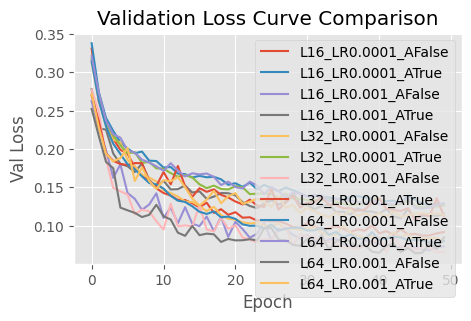

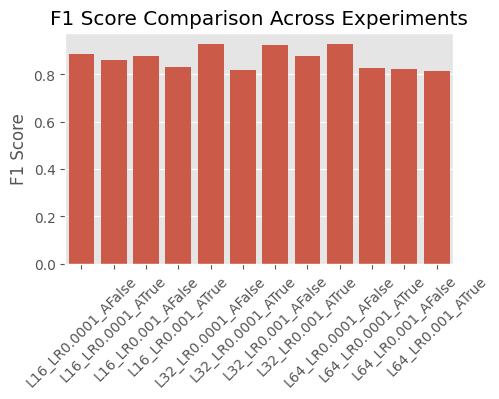

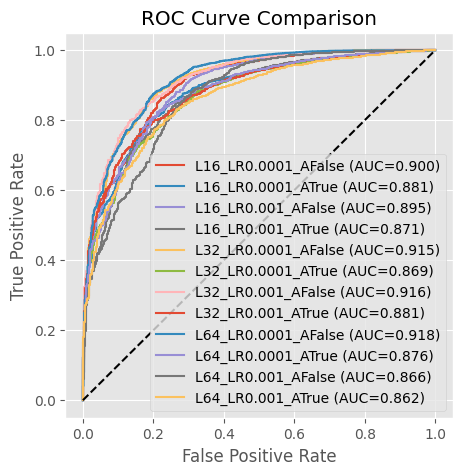

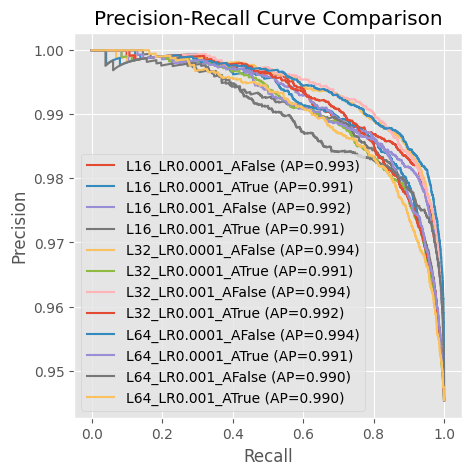

In [59]:
draw_comparison_plots(results)


Best Hyperparameters: (32, 0.0001, False)
Best Metrics: {'accuracy': 0.8744600431965442, 'precision': 0.9863335468716634, 'recall': 0.879390766301761, 'f1': 0.9297971918876755}


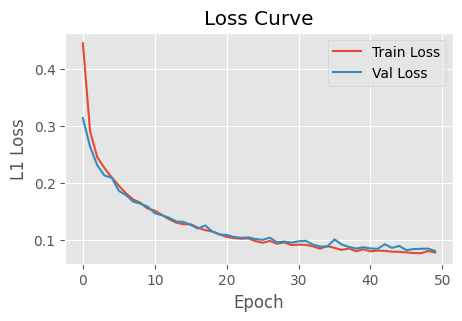

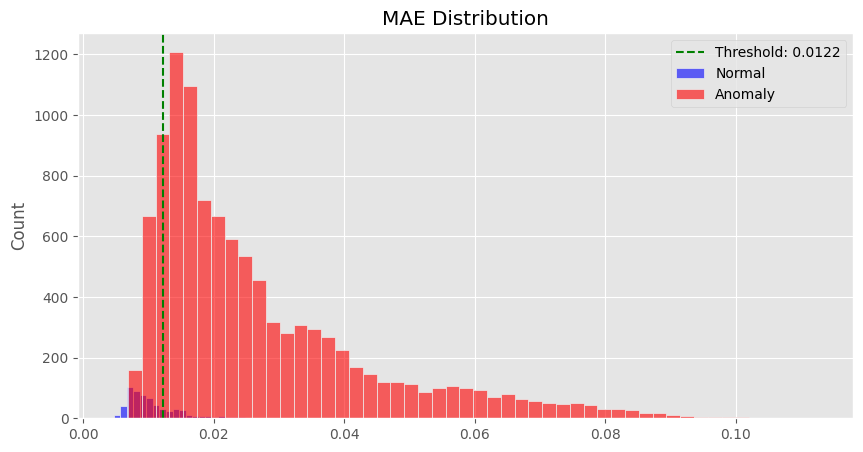

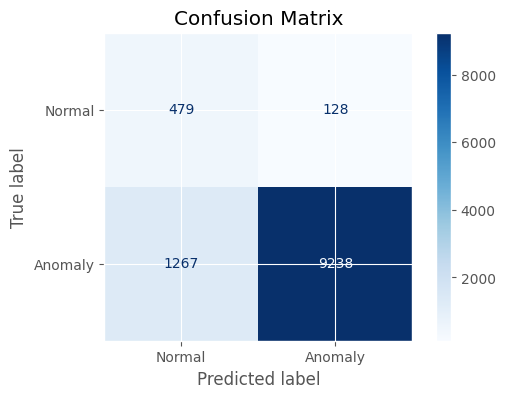

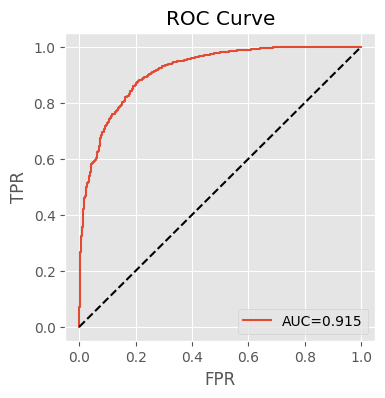

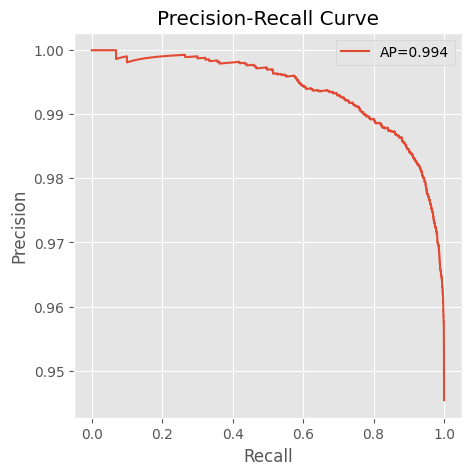

In [61]:
best_key = max(results.keys(), key=lambda k: results[k]["metrics"]["f1"])
best_result = results[best_key]

print("Best Hyperparameters:", best_key)
print("Best Metrics:", best_result["metrics"])

draw_single_experiment(best_result)


# Cross-sectional comparison of three types of hyperparameters

In [ ]:
def filter_results(results, latent=None, lr=None, aug=None):
    """Return a dictionary filtered by latent_dim / lr / augmentation."""
    out = {}
    for key, val in results.items():
        kd_latent, kd_lr, kd_aug = key
        if (latent is None or kd_latent == latent) and \
           (lr is None or kd_lr == lr) and \
           (aug is None or kd_aug == aug):
            out[key] = val
    return out


#F1
def plot_f1_comparison(result_subset, title="F1 Comparison"):
    labels = []
    f1_vals = []

    for key, res in result_subset.items():
        labels.append(str(key))
        f1_vals.append(res["metrics"]["f1"])

    plt.figure(figsize=(10,5))
    sns.barplot(x=labels, y=f1_vals)
    plt.title(title)
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45)
    plt.show()

#ROC
def plot_roc_comparison(result_subset, title="ROC Comparison"):
    plt.figure(figsize=(7,7))

    for key, res in result_subset.items():
        y_true = res["y_true"]
        y_scores = res["y_scores"]

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auc = roc_auc_score(y_true, y_scores)

        plt.plot(fpr, tpr, label=f"{key} (AUC={auc:.3f})")

    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# PR
def plot_pr_comparison(result_subset, title="Precision-Recall Comparison"):
    plt.figure(figsize=(7,7))

    for key, res in result_subset.items():
        y_true = res["y_true"]
        y_scores = res["y_scores"]

        prec, rec, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)

        plt.plot(rec, prec, label=f"{key} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def compare_latent_dim(results, lr, aug):
    subset = filter_results(results, lr=lr, aug=aug)
    title_suffix = f"(lr={lr}, aug={aug})"

    plot_f1_comparison(subset, f"F1 Comparison for different Latent Dim {title_suffix}")
    plot_roc_comparison(subset, f"ROC Comparison for different Latent Dim {title_suffix}")
    plot_pr_comparison(subset, f"PR Comparison for different Latent Dim {title_suffix}")

def compare_learning_rate(results, latent, aug):
    subset = filter_results(results, latent=latent, aug=aug)
    title_suffix = f"(latent={latent}, aug={aug})"

    plot_f1_comparison(subset, f"F1 Comparison for different LR {title_suffix}")
    plot_roc_comparison(subset, f"ROC Comparison for different LR {title_suffix}")
    plot_pr_comparison(subset, f"PR Comparison for different LR {title_suffix}")

def compare_augmentation(results, latent, lr):
    subset = filter_results(results, latent=latent, lr=lr)
    title_suffix = f"(latent={latent}, lr={lr})"

    plot_f1_comparison(subset, f"F1 Comparison for Augmentation {title_suffix}")
    plot_roc_comparison(subset, f"ROC Comparison for Augmentation {title_suffix}")
    plot_pr_comparison(subset, f"PR Comparison for Augmentation {title_suffix}")


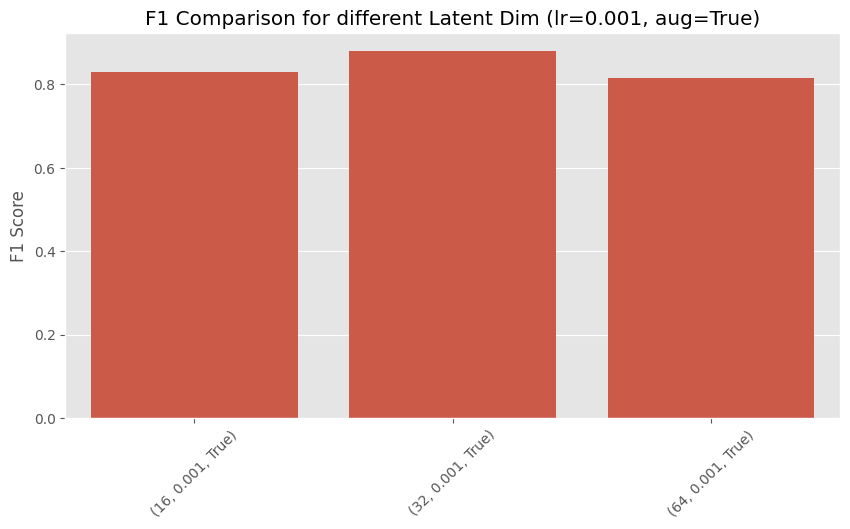

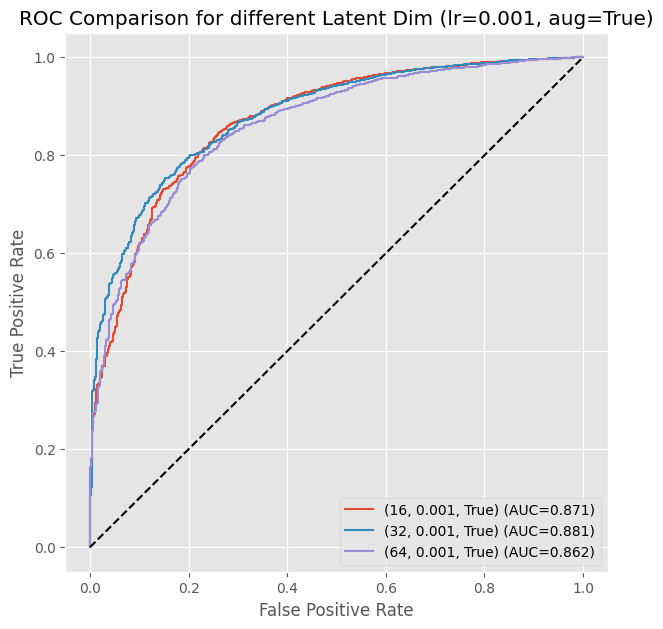

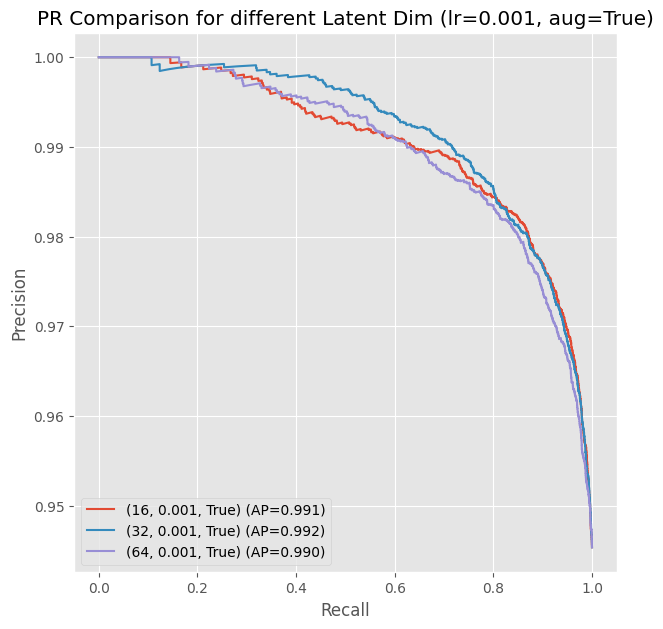

In [63]:
compare_latent_dim(results, lr=1e-3, aug=True)


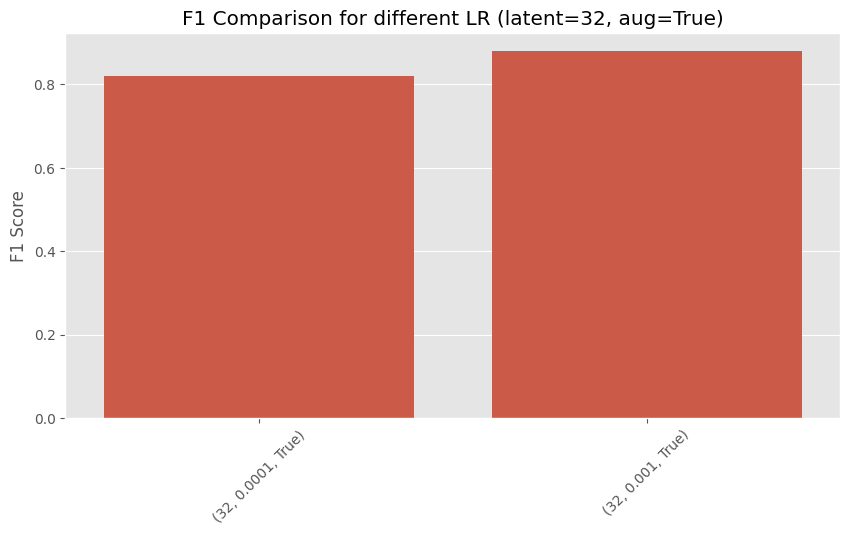

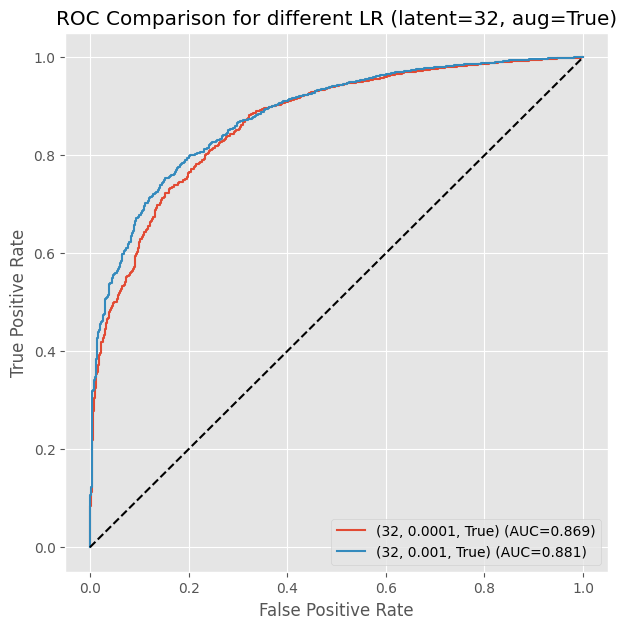

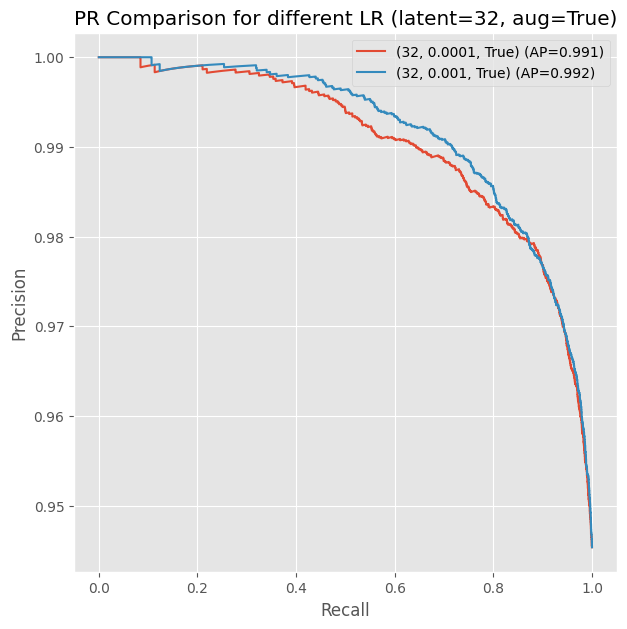

In [64]:
compare_learning_rate(results, latent=32, aug=True)


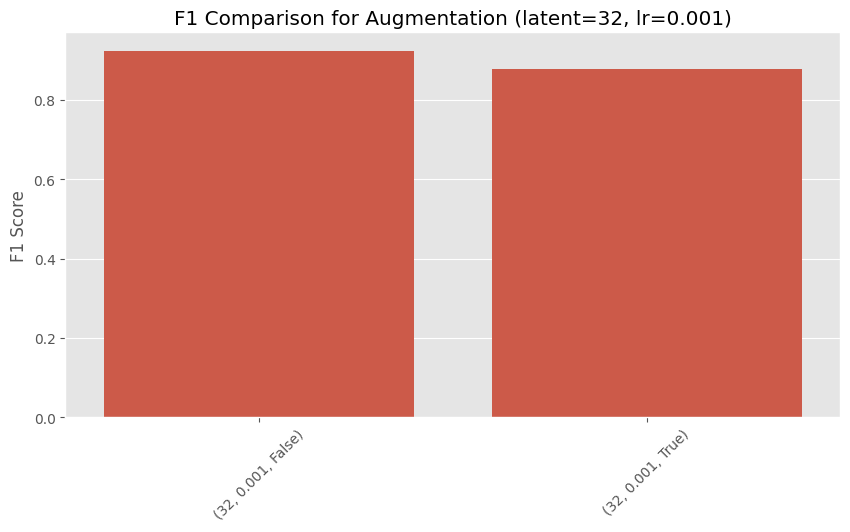

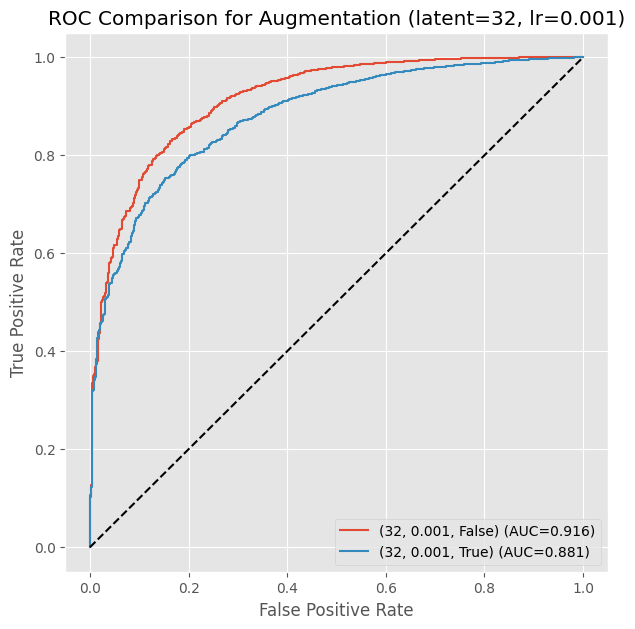

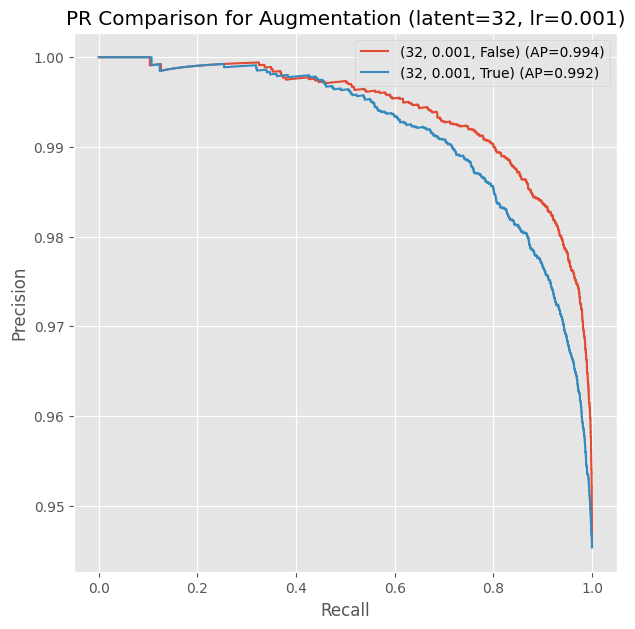

In [65]:
compare_augmentation(results, latent=32, lr=1e-3)
